In [20]:
import networkx as nx

In [21]:
G = nx.DiGraph()
G.add_edge('0', 'a1')
nx.set_node_attributes(G, { 'a1': 'A' }, "site")
G.add_edge('0', 'b1')
nx.set_node_attributes(G, { 'b1': 'B' }, "site")
G.add_edge('b1', 'b2')
nx.set_node_attributes(G, { 'b2': 'B' }, "site")

nodes = G.nodes
{k:v for (k,v) in map(lambda x: (x, 'node'), nodes)}

{'0': 'node', 'a1': 'node', 'b1': 'node', 'b2': 'node'}

In [22]:
nx.is_directed_acyclic_graph(G)

True

In [23]:
nx.dag_longest_path(G)

['0', 'b1', 'b2']

In [24]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def ancetres(node):
  predecessors = [pred for pred in G.predecessors(node)]
  return predecessors + flatten([ancetres(pred) for pred in predecessors])

ancetres('b2')

['b1', '0']

In [25]:
def concurrents(node_a, avec=list(G.nodes)):
  H = [n for n in avec if n not in ancetres(node_a)]
  H.remove(node_a)
  return [node_b for node_b in H if node_a not in ancetres(node_b)]

concurrents('b2')

['a1']

In [26]:
def conflits(node_a, avec=None):
  avec = avec or concurrents(node_a)
  parité = nx.dijkstra_path_length(G, source='0', target=node_a) % 2
  return [node_b for node_b in avec if parité is not nx.dijkstra_path_length(G, source='0', target=node_b) % 2]

conflits('b2')

['a1']

In [27]:
site = nx.get_node_attributes(G, "site")
site['b1']

'B'

In [28]:
site['a1'] > site['b2']

False

In [29]:
from functools import total_ordering

ORDER = [
  'A',
  'B',
  'C'
]

@total_ordering
class Site:
  def __init__(self, label):
      self.label = label

  def __eq__(self, other):
    return ORDER.index(self.label) == ORDER.index(other.label)

  def __lt__(self, other):
    return ORDER.index(self.label) > ORDER.index(other.label)

Site(label='A') > Site(label='B')

True

In [30]:
nx.set_node_attributes(G, { 'a1': Site(label='A') }, "site")
nx.set_node_attributes(G, { 'b1': Site(label='B') }, "site")
nx.set_node_attributes(G, { 'b2': Site(label='B') }, "site")
site = nx.get_node_attributes(G, "site")

site['a1'] > site['b2']

True

In [31]:
def résolution(node_a, node_b):
  # on peut imaginer d'autres stratégies…
  return site[node_a] > site[node_b]

def estValide(node):
  confs           = conflits(node)
  gagne_conflits  = all([résolution(node, conf) for conf in confs]) if len(confs) > 0 else True
  predecessors    = [pred for pred in G.predecessors(node)]
  parents_valides = all([estValide(pred) for pred in predecessors]) if len(predecessors) > 0 else True
  return gagne_conflits and parents_valides

for i in G.nodes:
  print("""{:2}: 
    concurrent avec : {}
    en conflit avec : {}
    validité : {}""".format(i, concurrents(i), conflits(i), estValide(i)))

0 : 
    concurrent avec : []
    en conflit avec : []
    validité : True
a1: 
    concurrent avec : ['b1', 'b2']
    en conflit avec : ['b2']
    validité : True
b1: 
    concurrent avec : ['a1']
    en conflit avec : []
    validité : True
b2: 
    concurrent avec : ['a1']
    en conflit avec : ['a1']
    validité : False


In [32]:
from typing import List, Dict


class DAG(nx.DiGraph):

    def ancetres(self, node: str) -> List[str]:
        predecessors = [pred for pred in self.predecessors(node)]
        return predecessors + flatten([self.ancetres(pred) for pred in predecessors])

    def concurrents(self, node_a) -> List[str]:
        H = [n for n in self.nodes if n not in self.ancetres(node_a)]
        H.remove(node_a) # list.remove
        return [node_b for node_b in H if node_a not in self.ancetres(node_b)]

    def conflits(self, node_a: str) -> List[str]:
        parité = nx.dijkstra_path_length(self, source='0', target=node_a) % 2
        return [
            node_b
            for node_b
            in self.concurrents(node_a)
            if parité is not nx.dijkstra_path_length(self, source='0', target=node_b) % 2
        ]

    def résolution(self, node_a: str, node_b: str):
        site = nx.get_node_attributes(self, "site")
        # on peut imaginer d'autres stratégies…
        return site[node_a] > site[node_b]

    def estValide(self, node: str) -> bool:
        _conflits       = self.conflits(node)
        gagne_conflits  = all([
            self.résolution(node, _conflit)
            for _conflit
            in _conflits
        ]) if len(_conflits) > 0 else True
        predecessors    = [pred for pred in self.predecessors(node)]
        parents_valides = all([
            self.estValide(pred)
            for pred
            in predecessors
        ]) if len(predecessors) > 0 else True
        valide = gagne_conflits and parents_valides
        nx.set_node_attributes(self, { node: valide }, "valide")
        return valide

    def dag_longest_valid_path(self) -> str:
        _self = self.copy()
        last_path = nx.dag_longest_path(_self)
        last = last_path[-1]
        while not self.estValide(last):
            _self.remove_node(last)
            last_path = nx.dag_longest_path(_self)
            last = last_path[-1]
        return last_path

    def draw(self):
        import matplotlib.pyplot as plt
    
        pos = nx.spring_layout(self)
        nx.draw(self, pos, node_color='gray', with_labels=True)
        
        valide = nx.get_node_attributes(self, "valide")
        invalides = [node for node in self.nodes if not self.estValide(node)]
        for node in self.nodes:
            nx.draw_networkx_nodes(self, pos, nodelist=invalides, node_color='r')
        
        path = self.dag_longest_valid_path()
        path_edges = list(zip(path,path[1:]))
        nx.draw_networkx_nodes(self, pos, nodelist=path, node_color='g')
        nx.draw_networkx_edges(self, pos, edgelist=path_edges, edge_color='g', width=5)
        
        plt.axis('equal')
        plt.show()


# Test ancetres
G = DAG()
G.add_edge('0', 'a1')
nx.set_node_attributes(G, { 'a1': Site(label='A') }, "site")
G.add_edge('0', 'b1')
nx.set_node_attributes(G, { 'b1': Site(label='B') }, "site")
G.add_edge('b1', 'b2')
nx.set_node_attributes(G, { 'b2': Site(label='B') }, "site")
assert G.ancetres('b2') == ['b1', '0']

# Test concurrents
assert G.concurrents('b1') == ['a1']

# Test conflits
assert G.conflits('b2') == ['a1']

# Test estValide
assert G.estValide('b2') == False
assert G.estValide('b1') == True

# Test plus long chemin valide
assert G.dag_longest_valid_path() == ['0', 'a1'] # et non 'b2' le plus long chemin

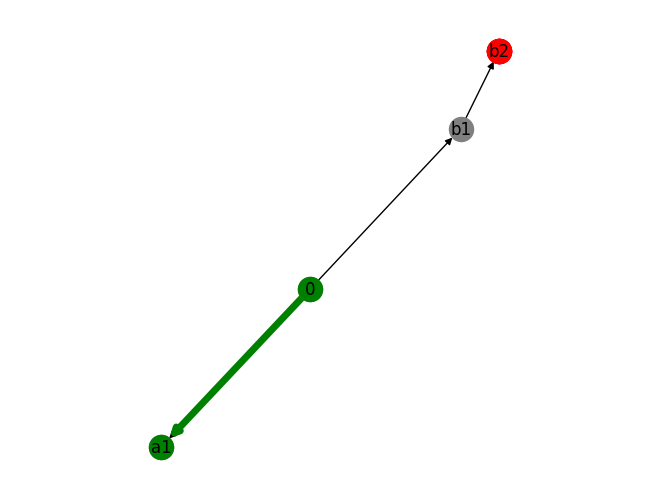

In [33]:
G.draw()

In [34]:
ORDER = [
  'B',
  'A'
]

G = DAG()
G.add_edge('0', 'a1')
nx.set_node_attributes(G, { 'a1': Site(label='A') }, "site")
G.add_edge('0', 'b1')
nx.set_node_attributes(G, { 'b1': Site(label='B') }, "site")
G.add_edge('b1', 'b2')
nx.set_node_attributes(G, { 'b2': Site(label='B') }, "site")
G.draw()

In [35]:
ORDER = [
  'C',
  'B',
  'A'
]

G_d = DAG()
G_d.add_edges_from([('0', 'a1'), ('a1', 'a2'), ('0', 'b1'), ('0', 'c1'), ('c1', 'c2')])
nx.set_node_attributes(G_d, { 'a1': Site(label='A') }, "site")
nx.set_node_attributes(G_d, { 'a2': Site(label='A') }, "site")
nx.set_node_attributes(G_d, { 'b1': Site(label='B') }, "site")
nx.set_node_attributes(G_d, { 'c1': Site(label='C') }, "site")
nx.set_node_attributes(G_d, { 'c2': Site(label='C') }, "site")
print(G_d.nodes)
G_d.estValide('c1')
G_d.draw()

['0', 'a1', 'a2', 'b1', 'c1', 'c2']


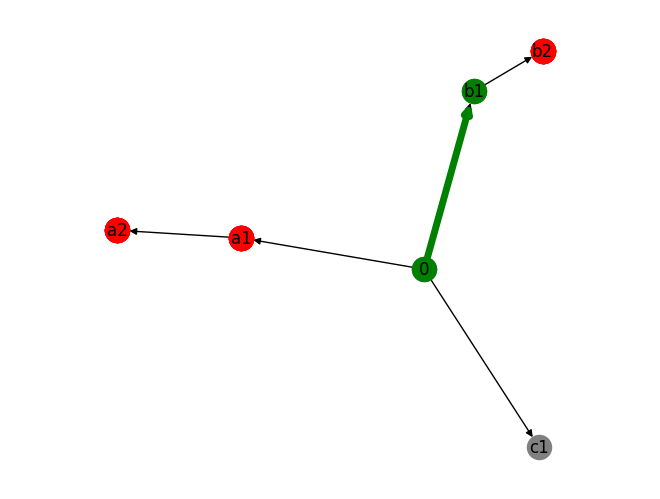

In [36]:
G_d = DAG()
G_d.add_edges_from([('0', 'a1'), ('a1', 'a2'), ('0', 'b1'), ('b1', 'b2'), ('0', 'c1')])
nx.set_node_attributes(G_d, { 'a1': Site(label='A') }, "site")
nx.set_node_attributes(G_d, { 'a2': Site(label='A') }, "site")
nx.set_node_attributes(G_d, { 'b1': Site(label='B') }, "site")
nx.set_node_attributes(G_d, { 'b2': Site(label='B') }, "site")
nx.set_node_attributes(G_d, { 'c1': Site(label='C') }, "site")
nx.set_node_attributes(G_d, { 'c2': Site(label='C') }, "site")
G_d.draw()

In [37]:
G_d = DAG()
G_d.add_edges_from([('0', 'a1'), ('0', 'b1'), ('b1', 'b2'), ('b2', 'b3')])
nx.set_node_attributes(G_d, { 'a1': Site(label='A') }, "site")
nx.set_node_attributes(G_d, { 'b1': Site(label='B') }, "site")
nx.set_node_attributes(G_d, { 'b2': Site(label='B') }, "site")
nx.set_node_attributes(G_d, { 'b3': Site(label='B') }, "site")
G_d.draw()

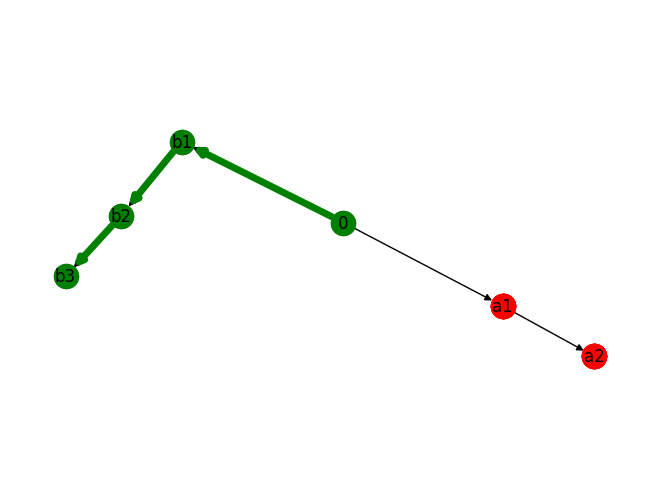

In [38]:
G_d = DAG()
G_d.add_edges_from([('0', 'a1'), ('a1', 'a2'), ('0', 'b1'), ('b1', 'b2'), ('b2', 'b3')])
nx.set_node_attributes(G_d, { 'a1': Site(label='A') }, "site")
nx.set_node_attributes(G_d, { 'a2': Site(label='A') }, "site")
nx.set_node_attributes(G_d, { 'b1': Site(label='B') }, "site")
nx.set_node_attributes(G_d, { 'b2': Site(label='B') }, "site")
nx.set_node_attributes(G_d, { 'b3': Site(label='B') }, "site")
G_d.draw()